<img src="img/mupiflogo.png" style="float:right;height:80px;">

# Interactive stationary thermo-mechanical workflow 
- Ilustrates how to use model APIs
- Ilustrates the use of data components (Properties and Fields)
- Shows how to combine these concepts and create first workflow

<img src="img/thermomechanicalModa.png" alt="Problem MODA" style="width: 600px;"/>

# Problem
*  Rectangular domain (l = 5, h = 1 [m])
*  boundary conditions (Dirichlet, Newton) can be applied on model edges

Edge numbering:
<pre>
     ----------3----------  
     |                   |  
     4                   2  
     |                   |  
     ----------1---------  
</pre>

In [1]:
# local machine only
import sys
sys.path.append('/home/bp/devel/mupif.git')

import matplotlib
# make figures larger
#matplotlib.rcParams['figure.figsize']=(20,20)

# this is ugly
# examples are not part of the mupif module now, thus are copied locally, should be re-considered
sys.path.append('.')
import models

In [2]:
import mupif as mp

 ### Create instances of individual models and get some info about them
 Here we create local instances of both models. To connect to a remote instance a different procedure is needed (and requires the connection information)

In [3]:
thermalSolver = models.ThermalModel()
thermalSolver.getApplicationSignature()

16:40:42 [1704|MainThread] WARNING:logger.py:211 UnitsWarning: 'W/m/K' contains multiple slashes, which is discouraged by the FITS standard


'Stationary thermal-demo-solver, ver 1.0'

In [4]:
mechanicalSolver = models.MechanicalModel()
mechanicalSolver.getApplicationSignature()

'Mechanical-demo-solver, ver 1.0'

### Initialize both model instances, by using *initialize* method, passing required input file  

In [5]:

thermalSolver.initialize()
#thermalInputFile = mp.PyroFile(filename='inputT.in', mode="rb", dataID=mp.DataID.ID_InputFile)
#thermalSolver.set(thermalInputFile)
mechanicalSolver.initialize()
#mechanicalInputFile = mp.PyroFile(filename='inputM2.in', mode="rb", dataID=mp.DataID.ID_InputFile)
#mechanicalSolver.set(mechanicalInputFile)

### Explore the Model Inputs/Outputs

The model metadata contain many useful information. 
- The model inputs are documented as metadata and can be retrieved using 'Input' key
- The model outputs can be retrieved using 'Output' key

In [6]:
thermalSolver.getMetadata('Inputs')

[{'Name': 'edge temperature',
  'Type': 'mupif.Property',
  'Required': False,
  'Type_ID': 'mupif.DataID.PID_Temperature',
  'Units': 'degC',
  'Obj_ID': ['Cauchy top',
   'Cauchy bottom',
   'Cauchy left',
   'Cauchy right',
   'Dirichlet top',
   'Dirichlet bottom',
   'Dirichlet left',
   'Dirichlet right'],
  'Set_at': 'timestep',
  'ValueType': 'Scalar'},
 {'Name': 'Input file',
  'Type': 'mupif.PyroFile',
  'Required': True,
  'Type_ID': 'mupif.DataID.ID_InputFile',
  'Obj_ID': 'input_file_thermal',
  'Set_at': 'initialization',
  'Units': 'none'}]

In [7]:
thermalSolver.getMetadata('Outputs')

[{'Name': 'temperature',
  'Type_ID': 'mupif.DataID.FID_Temperature',
  'Type': 'mupif.Field',
  'Required': False,
  'Units': 'degC'}]

### Set some inputs
The model inputs can be set using *set* service. It accepts a supported data type instance (which knows its physical meaning) and optional object_id
- we first create properties to represent boundary conditions
- then use *set* method to apply these to different edges (identified using object_id)

In [8]:
bc1 = mp.ConstantProperty(propID=mp.DataID.PID_Temperature, valueType=mp.ValueType.Scalar, value=(50,), unit=mp.U['K'])
bc2 = mp.ConstantProperty(propID=mp.DataID.PID_Temperature, valueType=mp.ValueType.Scalar, value=(20,), unit=mp.U['K'])
#thermalSolver.set(bc1, 'Cauchy top')
thermalSolver.set(bc1, 'Dirichlet top')
thermalSolver.set(bc2, 'Dirichlet bottom')

### Solve the thermal problem
- use *solveStep* method to solve the problem for the given time step

In [9]:
# solve 
thermalSolver.solveStep(mp.TimeStep(time=0,dt=.1,targetTime=1.,unit=mp.U.s))

### Request thermal field
- request the output variables (thermal field in our case) from solver using *get* (or *getField*) method (the fieldID is fieldID=mp.FieldID.FID_Temperature)
- visualize field using *plot2d* method. Fields can be also exprorted to vtk

100%|██████████| 40/40 [00:00<00:00, 6909.89 cells/s]

[20.] C


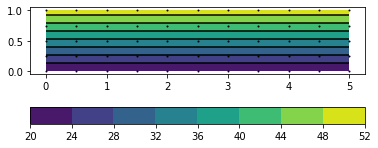

In [10]:
# show the field
f=thermalSolver.get(mp.DataID.FID_Temperature,time=1.*mp.Q.s)
f.plot2D()
print(f.evaluate((5,0,0)))

### Map thermal field to mechanical solver
- mapping the thermal field using mechanical model *set* method
- solving (updating) mechanical problem

In [11]:
bc1 = mp.ConstantProperty(propID=mp.DataID.FID_Displacement, valueType=mp.ValueType.Scalar, value=(0,0), unit=mp.U['m'])
mechanicalSolver.set(bc1, 'Dirichlet left')
#mechanicalSolver.set(bc1, 'Dirichlet right')

mechanicalSolver.set(f)
mechanicalSolver.solveStep(mp.TimeStep(time=0,dt=.1,targetTime=1.,unit=mp.U.s))

### Get outputs from mechanical problem
- use getField to request displacement field
- show displacement field (first component is defaul) on deformed configuration

100%|██████████| 160/160 [00:00<00:00, 6883.95 cells/s]


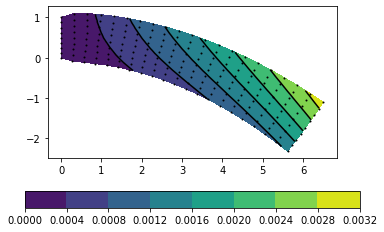

In [12]:
f=mechanicalSolver.get(mp.DataID.FID_Displacement,time=1.*mp.Q.s)
f.plot2D(warpField=f, warpScale=5.e2)

-6.0


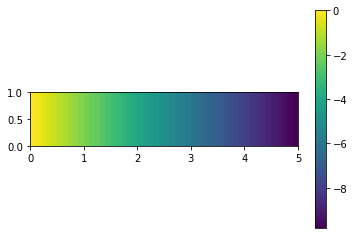

100%|██████████| 160/160 [00:00<00:00, 10763.42 cells/s]


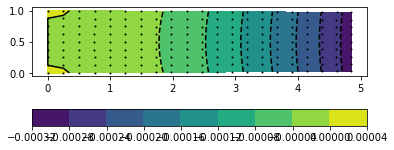

In [13]:
import analyticalfield as af

f = af.AnalyticalField(func=lambda x1,x2: 0.0-2*x1, fieldID=mp.DataID.FID_Temperature, unit=mp.U['K'])
f.evaluate((0,2))
f.plot2d()
mechanicalSolver.set(f)
mechanicalSolver.solveStep(mp.TimeStep(time=0,dt=.1,targetTime=1.,unit=mp.U.s))
f=mechanicalSolver.get(mp.DataID.FID_Displacement,time=1.*mp.Q.s)
f.plot2D(warpField=f, warpScale=5.e2)

In [14]:
mio=f.toMeshioMesh()

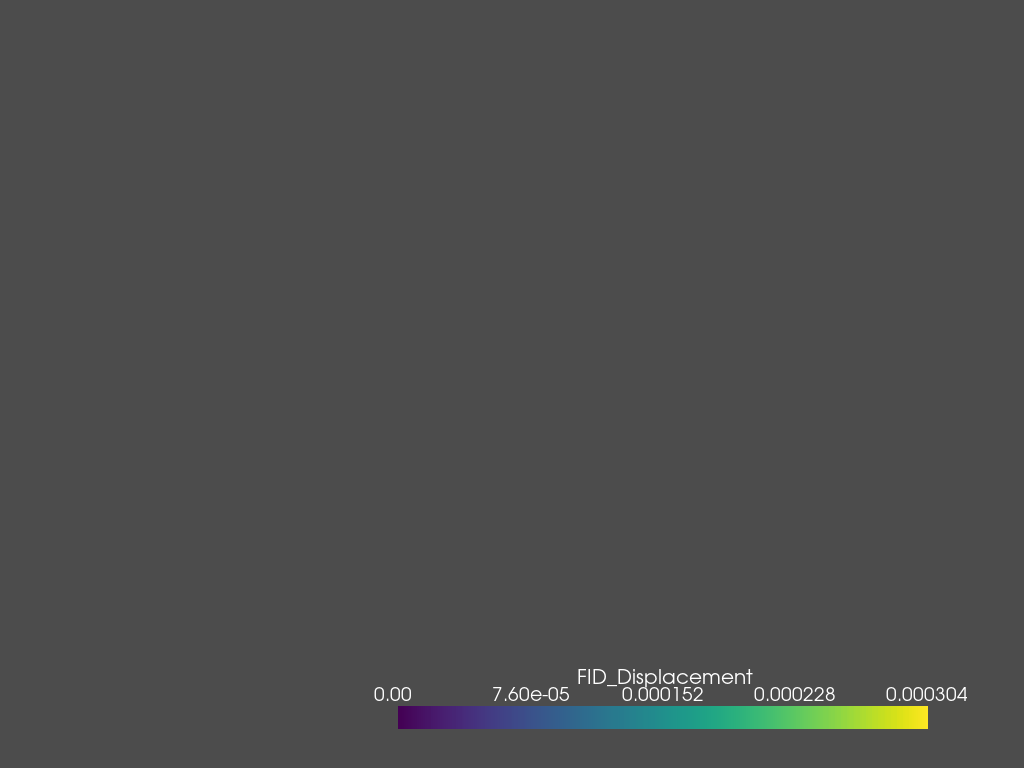

In [15]:
import pyvista as pv
pv.set_jupyter_backend('static')  
p = pv.Plotter()

mio=f.toMeshioMesh()
cloud = pv.wrap(mio)
warped = cloud.warp_by_vector(factor=100)
#print(cloud, warped)
p.add_mesh(warped, style='wireframe')
p.add_mesh(cloud, style='wireframe')
p.show(cpos="xy")

## Casting into workflow 
The above steps can be formalized into workflow represenation

MuPIF Workflow is represented as a class derived from *Workflow* class
- Workflow class inherits Model interface
- Adds *solve* method to run the whole worklfow
- Similar to models, workflows have to provide their medatadata as well

The example of workflow implementation for this examle is located in <a href="tmworkflow.py">tmworkflow module</a>


In [16]:
import tmworkflow
workflow = tmworkflow.Example06()

In [17]:

# define execution metadata, normally these are provided by scheduler
# but as we execute workflow manually, we neeed to provide these
md = {
    'Execution': {
        'ID': '1',
        'Use_case_ID': '1_1',
        'Task_ID': '1'
    }
}

# initialize workflow
workflow.initialize(metadata=md)# initialize workflow
#set some BCs
bc1 = mp.ConstantProperty(propID=mp.DataID.PID_Temperature, valueType=mp.ValueType.Scalar, value=(50,), unit=mp.U['K'])
bc2 = mp.ConstantProperty(propID=mp.DataID.PID_Temperature, valueType=mp.ValueType.Scalar, value=(0,), unit=mp.U['K'])
workflow.set(bc1, 'Cauchy top')
workflow.set(bc2, 'Dirichlet left')
workflow.set(bc2, 'Cauchy bottom')
#solve
workflow.solve()

16:40:46 [1704|MainThread] WARNING:logger.py:211 UnitsWarning: 'W/m/K' contains multiple slashes, which is discouraged by the FITS standard


Download finished.
Download finished.
Step 1: t=1 dt=1


100%|██████████| 50/50 [00:00<00:00, 11832.27 cells/s]


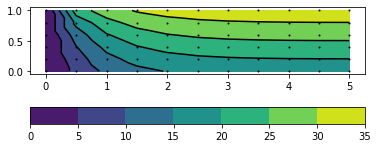

In [18]:
ft=workflow.get(mp.DataID.FID_Temperature,time=1.*mp.Q.s)
ft.plot2D()

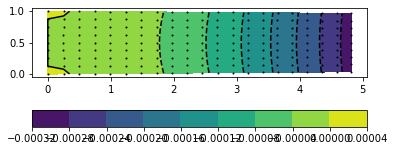

In [19]:
fd=mechanicalSolver.get(mp.DataID.FID_Displacement,time=1.*mp.Q.s)
fd.plot2D(warpField=fd, warpScale=6.e2)